# Examples with SGP4 library
Source: https://pypi.org/project/sgp4/ <br/>
Source: https://docs.astropy.org/en/stable/coordinates/satellites.html

Installation: `pip install sgp4`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sgp4.api import Satrec
from sys import stdout
from sgp4.conveniences import dump_satrec
from astropy.time import Time
from sgp4.api import SGP4_ERRORS
from astropy.coordinates import TEME, ITRS, CartesianDifferential, CartesianRepresentation
from astropy import units as u
import requests
import pandas as pd
import configparser
from astropy.coordinates import EarthLocation, AltAz
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from datetime import datetime as dt
import plotly.express as px

In [7]:
# Import local module
import TLE

In [9]:
objects_df, tle_df = TLE.get_latest_tle()

/class/gp/orderby/OBJECT_ID%20asc/emptyresult/show
<Response [200]>
<Response [200]>


## Get latest TLE from the ISS

### Step 1: get all TLE from Space-Track to update local database

In [11]:
tle_df

,OBJECT_ID,OBJECT_NAME,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,1958-001A,EXPLORER 1,0 EXPLORER 1,1 00004U 58001 A 70090.03500497 .07718844 +0...,2 00004 033.1468 334.6171 0024739 311.5310 048...
1,1958-002A,VANGUARD R/B,0 VANGUARD R/B,1 00016U 58002A 24077.49449400 .00000612 0...,2 00016 34.2742 161.1413 2024305 251.0406 86...
2,1958-002B,VANGUARD 1,0 VANGUARD 1,1 00005U 58002B 24076.04519752 .00000594 0...,2 00005 34.2462 334.3501 1840115 28.0389 340...
3,1958-002C,VANGUARD DEB,0 VANGUARD DEB,1 1576U 58002C 24077.73964683 .00001321 0...,2 1576 34.2296 219.7747 1428880 329.3506 23...
4,1958-004B,SPUTNIK 3,0 SPUTNIK 3,1 00008U 58004 B 60095.16166626 .02607090 +0...,2 00008 065.0599 163.5585 0088318 135.6760 224...
...,...,...,...,...,...
57823,UNKNOWN,TBA - TO BE ASSIGNED,0 TBA - TO BE ASSIGNED,1 81552U 24076.23945651 +.00001017 +0...,2 81552 99.0196 86.6439 0267443 104.2226 258...
57824,UNKNOWN,TBA - TO BE ASSIGNED,0 TBA - TO BE ASSIGNED,1 T0194U 24074.26645375 .00001448 0...,2 T0194 100.4558 275.0290 0051653 175.6828 184...
57825,UNKNOWN,TBA - TO BE ASSIGNED,0 TBA - TO BE ASSIGNED,1 89038U 19131.01706766 +.00169888 +0...,2 89038 098.8912 147.7329 0005786 040.6268 319...
57826,UNKNOWN,TBA - TO BE ASSIGNED,0 TBA - TO BE ASSIGNED,1 85246U 24077.60597096 +.00001227 +0...,2 85246 98.0408 134.5709 0232190 12.1320 348...


### Step 2: Create satellite objects using SGP4

In [78]:
def create_satrec_objects(tle_df):
# Args: tle_df (DataFrame)
# Output: dictionary with id, name and satellite object to use with sgp4


    # Initialise empty list
    orbital_objects = []

    for i, row in tle_df.iterrows():
        # Retrieve the object name
        object_id = row['OBJECT_ID']
        object_name = row['OBJECT_NAME']

        # Retrieve the TLE from the DataFrame row
        tle_l1 = row['TLE_LINE1']
        tle_l2 = row['TLE_LINE2']

        # Group data in a dictionary
        object_dict = {
            'id': object_id,
            'name': object_name,
            'satrec': Satrec.twoline2rv(tle_l1, tle_l2)
        }

        # Append dictionary to list of tracked objects
        orbital_objects.append(object_dict)

    # Print the number of objects created (list length)
    print(f"{len(orbital_objects)} objects created from TLE")

    return orbital_objects

In [13]:
def calculate_position(satellite, t, obs_station, verbose=False):

    # Calculate position and velocity with sgp4
    error_code, teme_p, teme_v = satellite.sgp4(t.jd1, t.jd2) # non-zero error code if the satellite position could not be computed for the given date.

    if error_code != 0:
        print(f"Error: {SGP4_ERRORS[error_code]}")
    else:
        if verbose:
            print('No error')

            # teme_p measures the satellite position in kilometers from the center of the earth in the
            # idiosyncratic True Equator Mean Equinox coordinate frame used by SGP4.
            print(f"Position [True Equator Mean Equinox]: {teme_p} (km)")

            # teme_v velocity is the rate at which the position is changing, expressed in kilometers
            # per second.
            print(f"Velocity [True Equator Mean Equinox]: {teme_v} (km/s)")

        # Convert from TEME to Other Coordinate Systems
        teme_p = CartesianRepresentation(teme_p*u.km)
        teme_v = CartesianDifferential(teme_v*u.km/u.s)

        # Note how we are careful to set the observed time of the TEME
        # frame to the time at which we calculated satellite position.
        teme = TEME(teme_p.with_differentials(teme_v), obstime=t)

        # to find the overhead latitude, longitude, and height of the satellite:
        itrs_geo = teme.transform_to(ITRS(obstime=t))
        itrs_geo = teme.transform_to(ITRS(obstime=t))
        location = itrs_geo.earth_location
        # to find the altitude and azimuth of the satellite from a particular location
        topo_itrs_repr = itrs_geo.cartesian.without_differentials() - obs_station.get_itrs(t).cartesian
        itrs_topo = ITRS(topo_itrs_repr, obstime = t, location=obs_station)
        aa = itrs_topo.transform_to(AltAz(obstime=t, location=obs_station))
        
        if verbose:
            print('Altitude / Azimuth')
            print(aa.alt.deg, aa.az.deg)

        # Transform azimuth to negative values for western positions
        if aa.az.deg <= 180:
            azimuth = aa.az.deg
        else:
            azimuth = aa.az.deg - 360

        satellite_1 = {
            'name': 'ISS',
            'alt': aa.alt.deg,
            'az': azimuth,
            'loc': location
        }

        return satellite_1

'2002-04-12T12:11:00.000000'

In [14]:
from zoneinfo import ZoneInfo

# Convert local time to UTC
local_tz = ZoneInfo("Australia/Sydney")  # For example, 'America/New_York'
local_time = dt.now(local_tz)
utc_time = local_time.astimezone(ZoneInfo("UTC"))

print("Local Time:", local_time)
print("UTC Time:", utc_time)

# Convert UTC to local time
utc_now = dt.now(ZoneInfo("UTC"))
local_time_converted = utc_now.astimezone(local_tz)

print("UTC Now:", utc_now)
print("Converted to Local Time:", local_time_converted)

Local Time: 2024-03-18 11:16:56.979351+11:00
UTC Time: 2024-03-18 00:16:56.979351+00:00
UTC Now: 2024-03-18 00:16:56.981351+00:00
Converted to Local Time: 2024-03-18 11:16:56.981351+11:00


In [15]:
dt.now().strftime(format='%Y-%m-%dT%H:%M:%S.%f')

'2024-03-18T11:16:59.451004'

In [86]:
year = 2024
month = 3
day = 6
hour = 17
minute = 22
second = 22

# Convert datetime to JD
# nominal_time = '2024-03-06T05:55:00.123456789'
nominal_time = dt(year, month, day, hour, minute, second)
nominal_time_str = nominal_time.strftime(format='%Y-%m-%dT%H:%M:%S.%f')
t = Time(nominal_time_str, format='isot', scale='utc')

# Provide the address of the observation station
address = '4 Ormond Road, Ormond, Vic 3204, Australia'
obs_station = EarthLocation.of_address(address)

# Find the objects by name
search_item = 'QB50P'
response_rows = tle_df.loc[tle_df['OBJECT_NAME'].str.contains(search_item, case=False)]
orbital_objects = create_satrec_objects(response_rows)

# Calculate the updated positions of each of the object
for obj in orbital_objects:
    object = obj['satrec']
    obj['new_position'] = calculate_position(object, t, obs_station)
    obj['nominal_time'] = nominal_time

2 objects created from TLE


In [85]:
orbital_objects

[{'id': '2014-033R',
  'name': 'QB50P1',
  'satrec': <sgp4.wrapper.Satrec at 0x18289e68000>,
  'new_position': {'name': 'ISS',
   'alt': -40.38227710553407,
   'az': -176.8017649409137,
   'loc': <EarthLocation (3435.9691188, -1927.0804219, -5747.41169332) km>},
  'nominal_time': datetime.datetime(2024, 3, 6, 17, 22, 22)},
 {'id': '2014-033Y',
  'name': 'QB50P2',
  'satrec': <sgp4.wrapper.Satrec at 0x18289e68820>,
  'new_position': {'name': 'ISS',
   'alt': -1.101646876282712,
   'az': -40.25080657729774,
   'loc': <EarthLocation (-4134.79641632, 5179.93228637, -2113.80300751) km>},
  'nominal_time': datetime.datetime(2024, 3, 6, 17, 22, 22)}]

In [92]:
orbital_objects[0]

-29.28610511110128

In [115]:
# Group the object information in lists
list_lon = [obj['new_position']['loc'].lon.deg for obj in orbital_objects]
list_lat = [obj['new_position']['loc'].lat.deg for obj in orbital_objects]
list_name = [obj['name'] for obj in orbital_objects]

# Create a DataFrame with the location of all the tracked objects
obs_df = pd.DataFrame({
    'longitude': list_lon,
    'latitude': list_lat,
    'type': len(list_name)*['Satellite'],
    'name': list_name
})

# Add the ground station to the DataFrame
obs_df.loc[len(obs_df.index)] = {
    'longitude': obs_station.lon.deg,
    'latitude': obs_station.lat.deg,
    'type': 'Ground Station',
    'name': 'Home'
}

In [116]:
obs_df

,longitude,latitude,type,name
0,-29.286105,-55.735598,Satellite,QB50P1
1,128.598046,-17.791280,Satellite,QB50P2
2,145.045098,-37.904457,Ground Station,Home


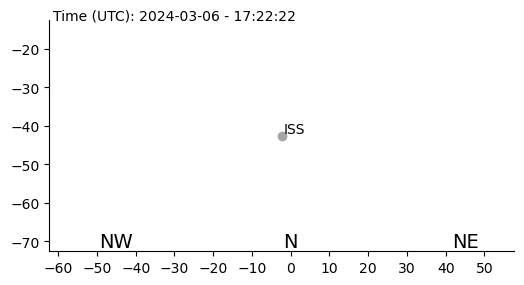

In [19]:
# Human Fielf of Vision
FOV_v = 60 # deg
FOV_h = 120 # deg

# Line of sight
los_az = satellite_1['az'] # deg away from North (positive = look East)
los_el = satellite_1['alt'] # deg above horizon

# Calculate FOV boundaries
x_min = -FOV_h/2 + los_az
x_max = FOV_h/2 + los_az
y_min = -FOV_v/2 + los_el
y_max = FOV_v/2 + los_el

scale_factor = 20

# Create figure
fig, ax = plt.subplots(figsize=(FOV_h/scale_factor, FOV_v/scale_factor))
sns.despine()

# Display horizon
ax.hlines(0, x_min, x_max, colors='k', ls=':')

# Display satellites
x_pos = satellite_1['az']
y_pos = satellite_1['alt']
s_name = satellite_1['name']

# Change color based on above/below horizon
if y_pos <= 0:
    color = '#a5a5a5'
else:
    color = '#00a8cc'

ax.scatter(x=x_pos, y=y_pos, c=color)
ax.annotate(s_name, [x_pos, y_pos], [x_pos+.5, y_pos], ha='left', va='bottom', fontsize=10)

# Display compass
ax.annotate('N', [0,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('NE', [45,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('E', [90,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('SE', [135,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('S', [180,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('S', [-180,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('SW', [-135,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('W', [-90,y_min], ha='center', va='bottom', fontsize=14)
ax.annotate('NW', [-45,y_min], ha='center', va='bottom', fontsize=14)
ax.set_xticks(np.arange(-360,360,10))

ax.text(x=x_min+1,y=y_max, s=f"Time (UTC): {dt.strptime(nominal_time_str[:26], '%Y-%m-%dT%H:%M:%S.%f').date()} - {dt.strptime(nominal_time_str[:26], '%Y-%m-%dT%H:%M:%S.%f').time()}")

# Set field of view limits
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()



# ==== WORLD MAP ==== 

px.scatter_mapbox(
    obs_df,
    lat = 'latitude',
    lon = 'longitude',
    center = {'lat': 0, 'lon':0},
    mapbox_style='open-street-map',
    zoom = 1.5,
).update_layout(
    mapbox=dict(
        bearing=0,
        center=dict(
            lat=0,
            lon=0
        ),
        pitch=0,
        zoom=1.2,
    ),
    margin=dict(l=10, r=10, t=10, b=10),  # Sets the margins to 0 pixels
    
    width=1200,  # Adjust width as necessary
    height=600  # Adjust height as necessary
)